In [ ]:
!wget -O "dataset.zip" "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded"

--2025-02-05 18:41:22--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd [following]
--2025-02-05 18:41:23--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 3.5.69.251, 52.92.0.162, 3.5.69.11, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|3.5.69.251|:443... conn

In [ ]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
replace Plant_leave_diseases_dataset_with_augmentation/Apple___Apple_scab/image (1).JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## DATA PREPROCESSING

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("/content/Plant_leave_diseases_dataset_with_augmentation", output="dataset", seed=1337, ratio=(.8, .1,.1))

Copying files: 61486 files [00:15, 3896.66 files/s]


In [ ]:
train_dir = "/content/dataset/train"
validation_dir = "/content/dataset/val"
test_dir = "/content/dataset/test"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 49179 files belonging to 39 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,

                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 6139 files belonging to 39 classes.
Found 6168 files belonging to 39 classes.


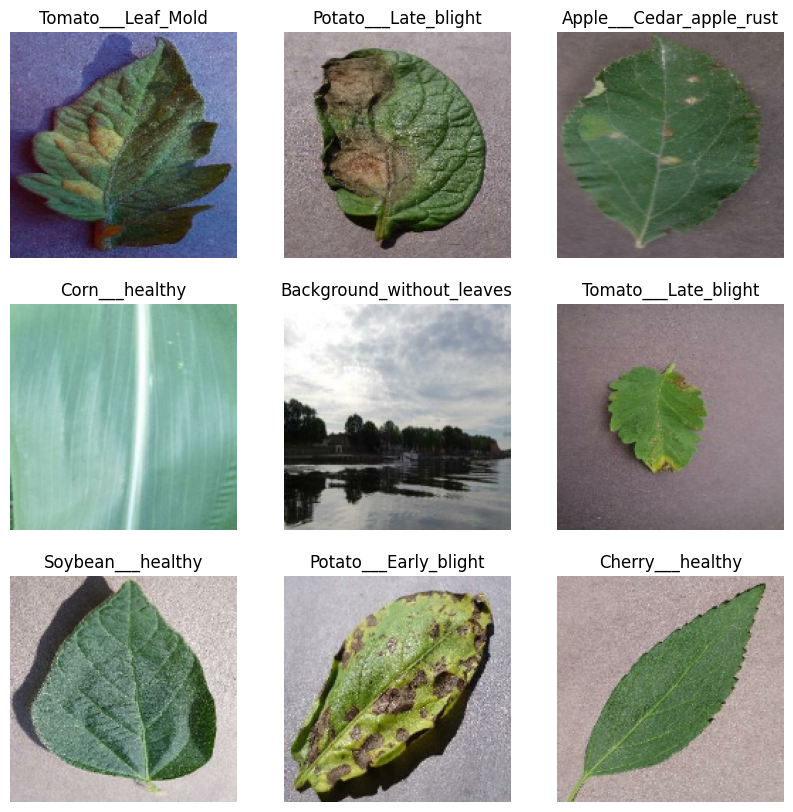

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot'

##Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

## Creating Base model for pretrained model EfficientNetB4

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB4(input_shape=IMG_SHAPE,
                                               include_top=False,
    weights='imagenet',
)


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1792)


## Feature Extraction

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetb4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 160, 160, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 160, 160, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 160, 160, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 161, 161, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 80, 80, 48)     │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 80, 80, 48)     │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 80, 80, 48)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 80, 80, 48)     │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 80, 80, 48)     │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 80, 80, 48)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 17,673,823 (67.42 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,673,823 (67.42 MB)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1792)


In [ ]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 39)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))

x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 5, 5, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1792)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 39)                  │          69,927 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,743,750 (67.69 MB)

 Trainable params: 69,927 (273.15 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [ ]:
len(model.trainable_variables)

2

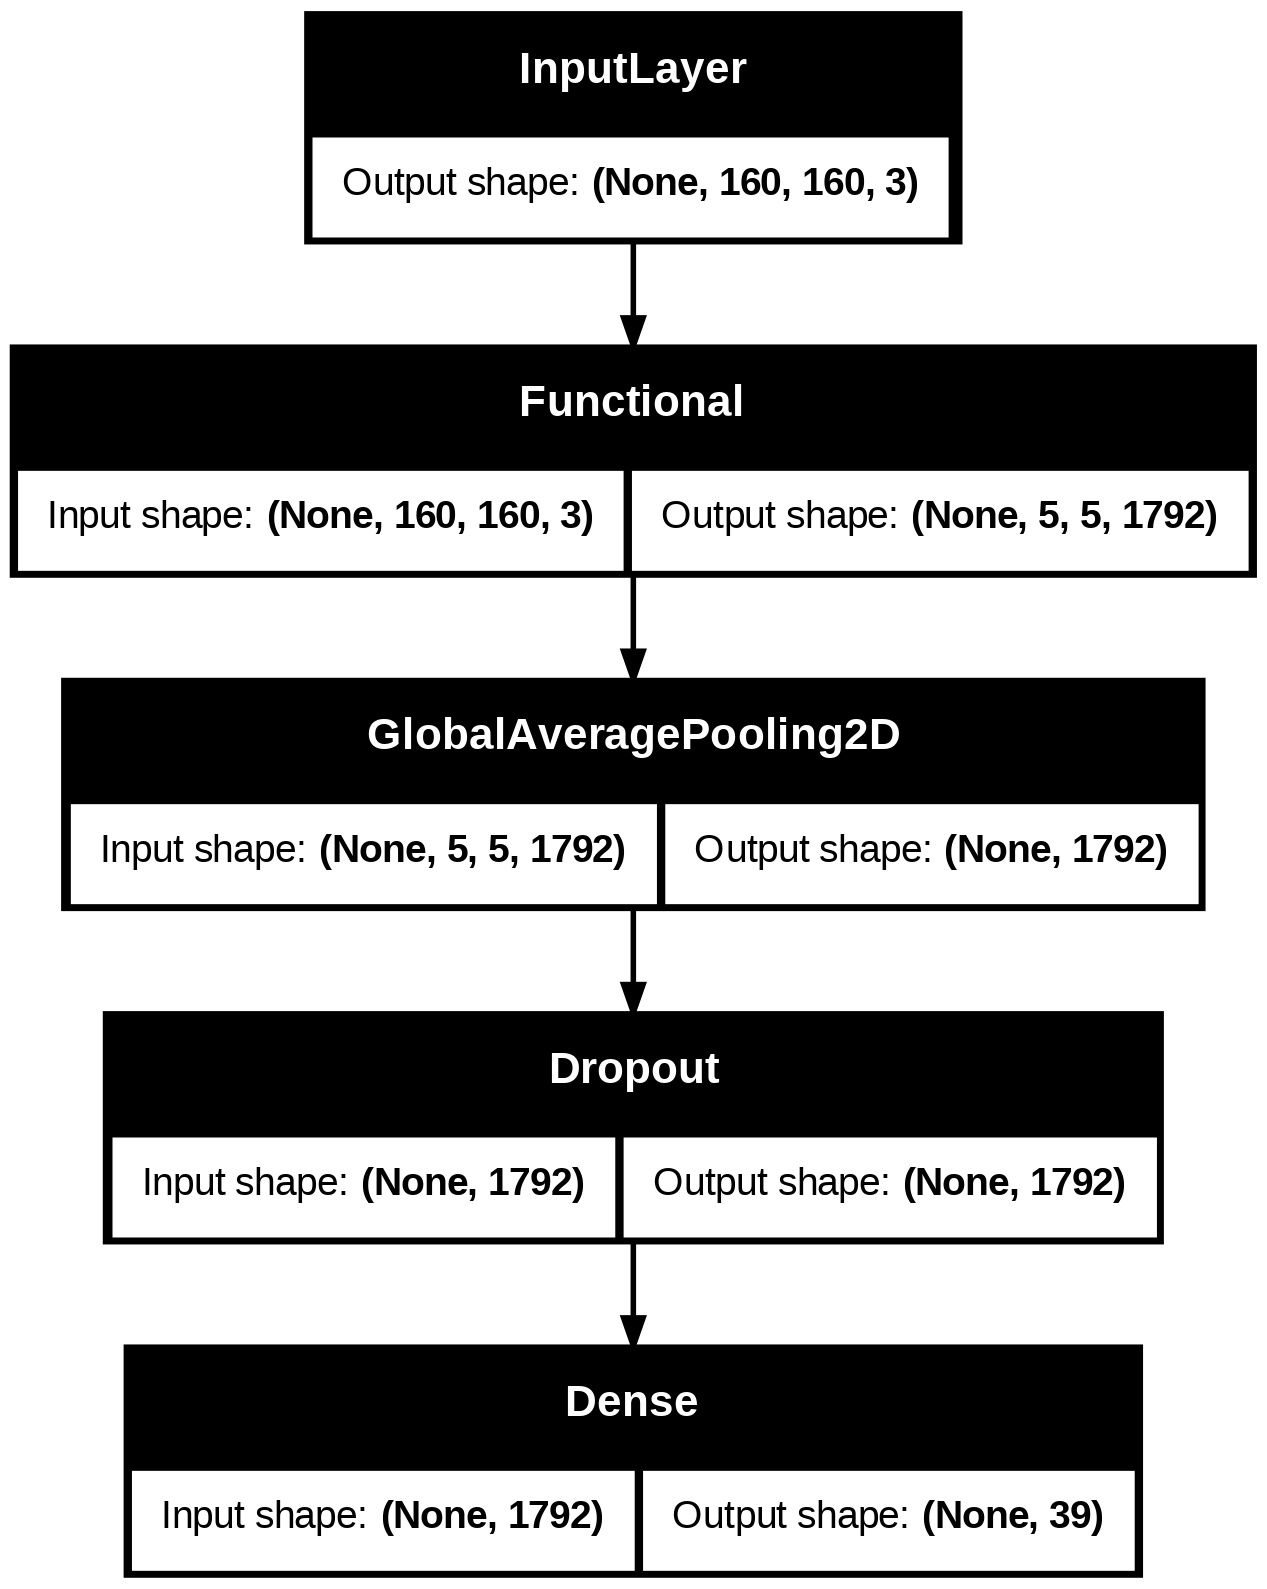

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Compile the model

In [ ]:

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [ ]:
initial_epochs = 6

loss0, accuracy0 = model.evaluate(validation_dataset)

192/192 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.0224 - loss: 3.8101


## Train the model

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 156s 75ms/step - accuracy: 0.6958 - loss: 1.2216 - val_accuracy: 0.9106 - val_loss: 0.3434
Epoch 2/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 103s 64ms/step - accuracy: 0.8978 - loss: 0.3662 - val_accuracy: 0.9329 - val_loss: 0.2426
Epoch 3/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 142s 64ms/step - accuracy: 0.9161 - loss: 0.2834 - val_accuracy: 0.9404 - val_loss: 0.2037
Epoch 4/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 101s 65ms/step - accuracy: 0.9259 - loss: 0.2439 - val_accuracy: 0.9480 - val_loss: 0.1802
Epoch 5/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 143s 66ms/step - accuracy: 0.9336 - loss: 0.2175 - val_accuracy: 0.9485 - val_loss: 0.1658
Epoch 6/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 138s 64ms/step - accuracy: 0.9363 - loss: 0.2034 - val_accuracy: 0.9515 - val_loss: 0.1566


## Learning Curves

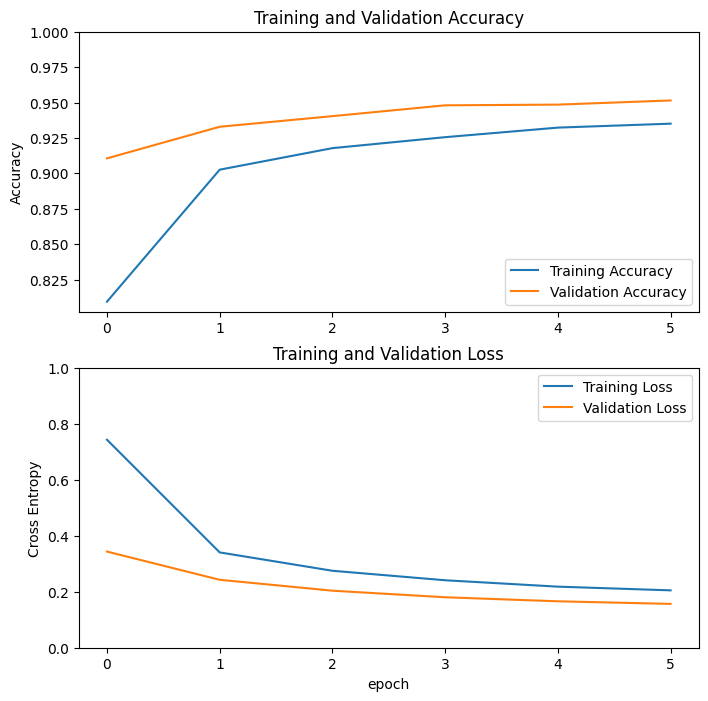

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

In [ ]:
base_model.trainable =True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  475


In [ ]:

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [ ]:

 # Let's take a look at the base model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 5, 5, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1792)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 39)                  │          69,927 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,743,750 (67.69 MB)

 Trainable params: 17,531,783 (66.88 MB)

 Non-trainable params: 211,967 (828.00 KB)

In [ ]:
len(model.trainable_variables)

333

## Continue training the model

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 7/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 473s 231ms/step - accuracy: 0.8790 - loss: 0.4138 - val_accuracy: 0.9682 - val_loss: 0.0749
Epoch 8/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 280s 164ms/step - accuracy: 0.9656 - loss: 0.0895 - val_accuracy: 0.9555 - val_loss: 0.0892
Epoch 9/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 265s 166ms/step - accuracy: 0.9654 - loss: 0.0738 - val_accuracy: 0.9697 - val_loss: 0.0696
Epoch 10/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 259s 165ms/step - accuracy: 0.9734 - loss: 0.0606 - val_accuracy: 0.9298 - val_loss: 0.0681
Epoch 11/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 251s 163ms/step - accuracy: 0.9689 - loss: 0.0616 - val_accuracy: 0.9713 - val_loss: 0.0902
Epoch 12/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 260s 162ms/step - accuracy: 0.9742 - loss: 0.0472 - val_accuracy: 0.9365 - val_loss: 0.0623
Epoch 13/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 249s 162ms/step - accuracy: 0.9671 - loss: 0.0388 - val_accuracy: 0.8669 - val_loss: 0.2162
Epoch 14/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 251s 163ms/step

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

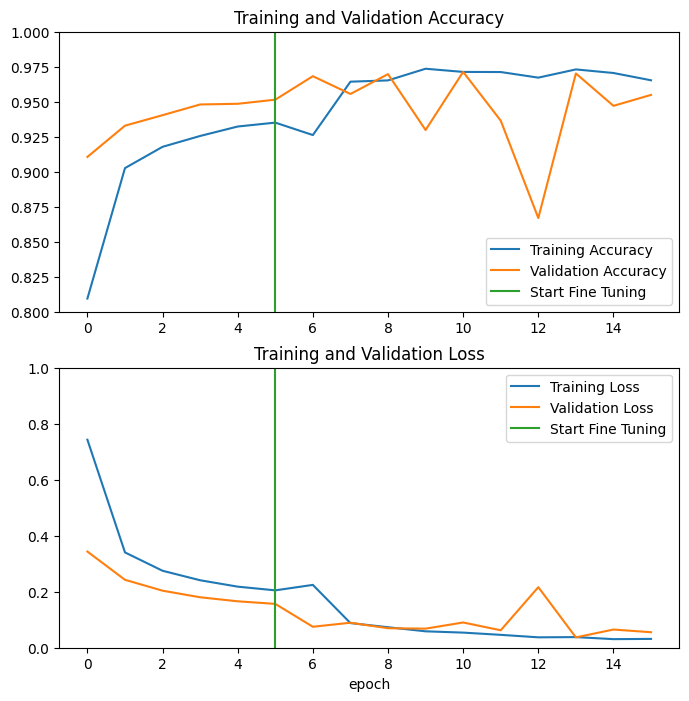

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and Prediction

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

193/193 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9541 - loss: 0.0581
Test accuracy : 0.9547665119171143


Predictions:
 [ 6 36 13 21 29 25 29 23 13 30 33 25 13 21 30 29 27 14 25 29 28 25 31 36
 14 20 28 35 27  6  5 36]
Labels:
 [ 6 36 13 21 29 25 29 23 13 30 33 28 13 21 30 29 27 14 25 29 28 25 31 36
 14 20 28 35 27  6 25 36]


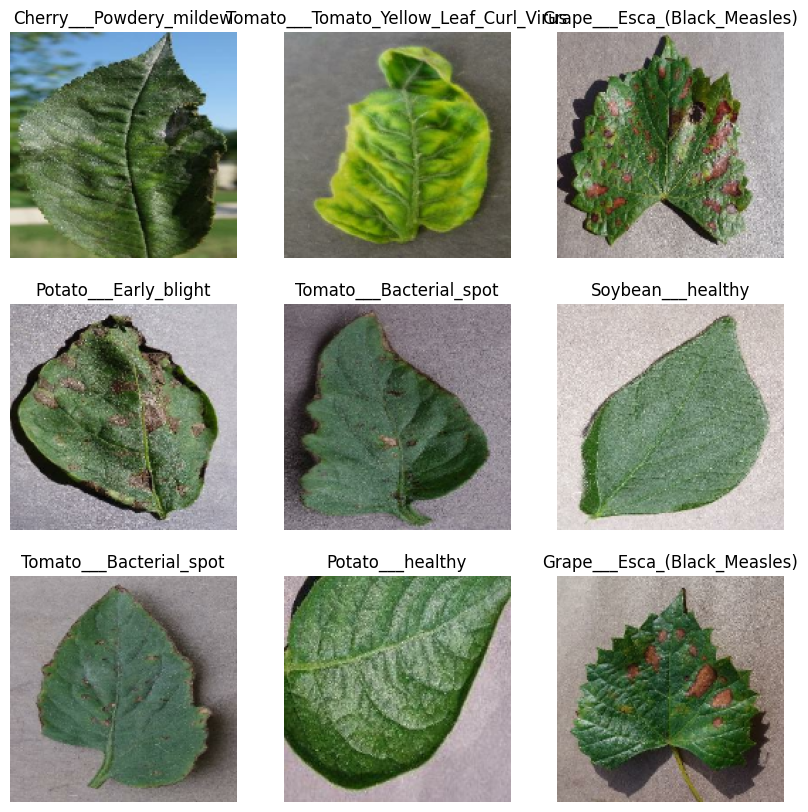

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions ,axis=1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

##Saving the model

In [ ]:
 model.save("plant_disease_recog_model_pwp.keras")

In [ ]:
model.save("/content/drive/MyDrive/plant_disease_recog_model_pwp.keras")